<a href="https://colab.research.google.com/github/Linsen-gao-457/AutoTune-TR/blob/main/AutoTune_TR_vs_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 8.1 MB/s eta 0:00:00


In [ ]:
!pip install tabulate

In [ ]:
import os
import pickle
import tempfile
from pathlib import Path
from functools import partial
from tabulate import tabulate
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

from ray import train, tune
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
from ray.tune import Trainable, CLIReporter

from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint
import tempfile
from pathlib import Path
import pandas as pd


In [ ]:
def load_data(data_dir="./data"):
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform
    )

    return trainset, testset

In [ ]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class SubsampledTrustRegion:
    def __init__(self, parameters, lr, radius=0.01):
        self.parameters = list(parameters)
        self.lr = lr
        self.radius = radius
        self.internal_state = {}
    def step(self, loss):
        self.zero_grad()

        grads = torch.autograd.grad(loss, self.parameters, create_graph=True)

        for p, g in zip(self.parameters, grads):
            if g is None:
                continue

            hvp = torch.autograd.grad(
                outputs=g, inputs=p, grad_outputs=g.detach(), retain_graph=True
            )[0]

            denom = hvp.norm() + 1e-6
            step = -self.lr * g / denom
            step = step.clamp(min=-self.radius, max=self.radius)

            with torch.no_grad():
              p.data = p.data + step


    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def state_dict(self):
        return {"lr": self.lr, "internal_state": self.internal_state}

    def load_state_dict(self, state_dict):
        self.lr = state_dict.get("lr", self.lr)
        self.radius = state_dict.get("radius", self.radius)


In [ ]:
def train_cifar(config, data_dir=None):
    print(f"Launching trial with config: {config}")
    torch.autograd.set_detect_anomaly(True)
    net = Net(config["l1"], config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()

    if config["optimizer"] == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "tr":
        optimizer = SubsampledTrustRegion(net.parameters(), lr=config["lr"])
    else:
        raise ValueError(f"Unknown optimizer: {config['optimizer']}")

    checkpoint = train.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            net.load_state_dict(checkpoint_state["net_state_dict"])
            if config["optimizer"] == "sgd":
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    trainset, testset = load_data(data_dir)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_subset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=2)

    for epoch in range(start_epoch, 10):
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            if config["optimizer"] == "tr":
                optimizer.step(loss)
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / epoch_steps))
                running_loss = 0.0

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": net.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)
            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report({"loss": val_loss / val_steps, "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")

In [ ]:
def evaluate_best_trials(result, data_dir, gpus_per_trial=0):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    accuracies = {}
    trial_data = []

    for optimizer in ["sgd", "tr"]:
        print(f"\nEvaluating best model for optimizer: {optimizer}")
        trials = [t for t in result.trials if t.config["optimizer"] == optimizer and t.last_result is not None]
        if not trials:
            print(f"No completed trials for optimizer {optimizer.upper()}")
            continue
        trial = max(trials, key=lambda t: t.last_result["accuracy"])
        model = Net(trial.config["l1"], trial.config["l2"])
        if gpus_per_trial > 1:
            model = nn.DataParallel(model)
        model.to(device)

        checkpoint = result.get_best_checkpoint(trial=trial, metric="accuracy", mode="max")
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                data = pickle.load(fp)
            model.load_state_dict(data["net_state_dict"])

        test_acc = test_accuracy(model, device)
        accuracies[optimizer.upper()] = test_acc
        print(f"Test accuracy for {optimizer.upper()}: {test_acc:.4f}")

    # Print table of all trials
    headers = ["Trial name", "status", "l1", "l2", "lr", "batch_size", "iter", "time (s)", "loss", "accuracy"]
    rows = []
    for trial in result.trials:
        config = trial.config
        result_data = trial.last_result if trial.last_result else {}
        rows.append([
            trial.trial_id,
            trial.status,
            config.get("l1", "-"),
            config.get("l2", "-"),
            f"{config.get('lr', 0):.5f}",
            config.get("batch_size", "-"),
            result_data.get("training_iteration", "-"),
            f"{result_data.get('time_total_s', 0):.1f}" if result_data else "-",
            f"{result_data.get('loss', 0):.4f}" if result_data else "-",
            f"{result_data.get('accuracy', 0):.4f}" if result_data else "-",
        ])
    print("\n" + tabulate(rows, headers=headers, tablefmt="grid"))

    return pd.DataFrame([
        {
            "trial_id": t.trial_id,
            "optimizer": t.config.get("optimizer", "-"),
            "accuracy": t.last_result.get("accuracy", 0) if t.last_result else 0
        }
        for t in result.trials if t.last_result is not None
    ])

def plot_results(trial_data):
    if not trial_data.empty:
        plt.figure(figsize=(10, 6))

        for opt in trial_data["optimizer"].unique():
            subset = trial_data[trial_data["optimizer"] == opt].sort_index()
            plt.plot(subset.index, subset["accuracy"], marker='o', label=f"{opt.upper()} (avg={subset['accuracy'].mean():.2f})")
            avg_line = [subset["accuracy"].mean()] * len(subset)
            plt.plot(subset.index, avg_line, linestyle='--', label=f"{opt.upper()} Avg Line")

        plt.title("Validation Accuracy by Trial")
        plt.xlabel("Trial Index")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

def main(num_samples=2, max_num_epochs=10, gpus_per_trial=0):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    search_space = []
    for i in range(num_samples):
        optimizer = "tr" if i < num_samples // 2 else "sgd"
        search_space.append({
            "l1": tune.choice([2**i for i in range(9)]),
            "l2": tune.choice([2**i for i in range(9)]),
            "lr": tune.loguniform(1e-3, 1e-1),
            "batch_size": tune.choice([2, 4, 8, 16]),
            "optimizer": optimizer
        })

    scheduler = ASHAScheduler(metric="loss", mode="min", max_t=max_num_epochs, grace_period=1, reduction_factor=2)

    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=tune.grid_search(search_space),
        scheduler=scheduler,
    )

    trial_data = evaluate_best_trials(result, data_dir, gpus_per_trial)
    plot_results(trial_data)

if __name__ == "__main__":
    main(num_samples=20, max_num_epochs=10, gpus_per_trial=0)


100%|██████████| 170M/170M [00:02<00:00, 71.6MB/s]
2025-04-23 11:46:43,363	INFO worker.py:1852 -- Started a local Ray instance.
2025-04-23 11:46:45,679	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-04-23 11:46:45,869	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2025-04-23 11:46:45,870	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2025-04-23_11-46-45   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        AsyncHyperBandScheduler           |
| Number of trials                 20                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2025-04-23_11-46-45

Trial status: 20 PENDING
Current time: 2025-04-23 11:46:46. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+------------------------------------+
| Trial name                status   |
+------------------------------------+
| train_cifar_a21e4_00000   PENDING  |
| train_cifar_a21e4_00001   PENDING  |
| train_cifar_a21e4_00002   PENDING  |
| train_cifar_a21e4_00003   PENDING  |
| train_cifar_a21e4_0000

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000000)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 11:50:46. Total running time: 4min 0s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         1            226.857   1.78898       0.3374 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING         

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000001)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 11:54:47. Total running time: 8min 1s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         2            450.589   1.75471       0.3516 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING         

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000002)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 11:58:17. Total running time: 11min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         3            679.471   1.72978       0.3646 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING       

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000003)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 12:02:17. Total running time: 15min 31s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         4            906.263   1.72627       0.3708 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING       

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000004)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 12:06:18. Total running time: 19min 32s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         5             1136.1   1.73108       0.3584 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING       

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000005)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 12:09:48. Total running time: 23min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         6            1363.78   1.70494       0.3814 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING        

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000006)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 12:13:48. Total running time: 27min 2s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         7            1591.46   1.71594       0.3739 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING        

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000007)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 12:17:18. Total running time: 30min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+--------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)     loss     accuracy |
+--------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         8            1819.58   1.7055       0.3802 |
| train_cifar_a21e4_00001   PENDING                                                    |
| train_cifar_a21e4_00002   PENDING                                                    |
| train_cifar_a21e4_00003   PENDING                                                    |
| train_cifar_a21e4_00004   PENDING                                                    |
| train_cifar_a21e4_00005   PENDING                                                    |
| train_cifar_a21e4_00006   PENDING                

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000008)



Trial status: 1 RUNNING | 19 PENDING
Current time: 2025-04-23 12:21:19. Total running time: 34min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------+
| Trial name                status       iter     total time (s)      loss     accuracy |
+---------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   RUNNING         9            2049.01   1.70091       0.3805 |
| train_cifar_a21e4_00001   PENDING                                                     |
| train_cifar_a21e4_00002   PENDING                                                     |
| train_cifar_a21e4_00003   PENDING                                                     |
| train_cifar_a21e4_00004   PENDING                                                     |
| train_cifar_a21e4_00005   PENDING                                                     |
| train_cifar_a21e4_00006   PENDING       

(func pid=874) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00000_0_config=l1_128_l2_32_lr_0_018109711181944637_batch_size_8_optimizer_tr,batch_size=8,l1=128,l2=32,lr=0.018_2025-04-23_11-46-46/checkpoint_000009)



Trial train_cifar_a21e4_00001 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_a21e4_00001 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                           256 |
| l2                                             4 |
| lr                                       0.01916 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=10419) Launching trial with config: {'l1': 256, 'l2': 4, 'lr': 0.019156785402841492, 'batch_size': 8, 'optimizer': 'tr'}

Trial status: 1 TERMINATED | 1 RUNNING | 18 PENDING
Current time: 2025-04-23 12:25:19. Total running time: 38min 33s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)     loss    

(func pid=10419) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00001_1_config=l1_256_l2_4_lr_0_019156785402841492_batch_size_8_optimizer_tr,batch_size=8,l1=256,l2=4,lr=0.0192_2025-04-23_11-46-46/checkpoint_000000)



Trial train_cifar_a21e4_00001 finished iteration 1 at 2025-04-23 12:29:04. Total running time: 42min 18s
+-------------------------------------------------------------+
| Trial train_cifar_a21e4_00001 result                        |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                  244.36903 |
| time_total_s                                      244.36903 |
| training_iteration                                        1 |
| accuracy                                             0.1023 |
| loss                                     2.3068342208862305 |
+-------------------------------------------------------------+
Trial train_cifar_a21e4_00001 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00001_1_config=l1_256_l2_4_lr_0_019156785402841492_batch_size_8_optimizer_tr,batch_size=8,l1=256,l2=4,lr=0.019

(func pid=11540) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00002_2_config=l1_64_l2_256_lr_0_0032918022868599927_batch_size_16_optimizer_tr,batch_size=16,l1=64,l2=256,lr=0._2025-04-23_11-46-46/checkpoint_000000)



Trial status: 2 TERMINATED | 1 RUNNING | 17 PENDING
Current time: 2025-04-23 12:31:50. Total running time: 45min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00002   RUNNING           1            152.812   2.03415       0.2536 |
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00003   PENDING                                                       |
| train_cifar_a21e4_00004   PENDING                                                       |
| train_cifar_a21e4_00005   PENDING                                                       |
| train_ci

(func pid=11540) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00002_2_config=l1_64_l2_256_lr_0_0032918022868599927_batch_size_16_optimizer_tr,batch_size=16,l1=64,l2=256,lr=0._2025-04-23_11-46-46/checkpoint_000001)
(func pid=11540) *** SIGSEGV received at time=1745411655 on cpu 1 ***
(func pid=11540) PC: @     0x79a05c5635de  (unknown)  ray::gcs::TaskInfoAccessor::AsyncAddTaskEventData()
(func pid=11540)     @     0x79a05dd73520       1824  (unknown)
(func pid=11540)     @     0x79a05c441ce5       1392  ray::core::worker::TaskEventBufferImpl::FlushEvents()
(func pid=11540)     @     0x79a05c3c818c       1488  ray::core::CoreWorker::Disconnect()
(func pid=11540)     @     0x79a05c3c86bd       1152  ray::core::CoreWorker::ForceExit()
(func pid=11540)     @     0x79a05c3c8aef       1680  ray::core::CoreWorker::HandleKillActor()
(func pid=11540)     @     0x79a05c3bfe74        192  ray::rpc::ServerC


Trial status: 3 TERMINATED | 17 PENDING
Current time: 2025-04-23 12:34:20. Total running time: 47min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2            301.656   1.99585       0.2519 |
| train_cifar_a21e4_00003   PENDING                                                       |
| train_cifar_a21e4_00004   PENDING                                                       |
| train_cifar_a21e4_00005   PENDING                                                       |
| train_cifar_a21e4_0

(func pid=12908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00003_3_config=l1_4_l2_128_lr_0_004272135845987294_batch_size_8_optimizer_tr,batch_size=8,l1=4,l2=128,lr=0.0043_2025-04-23_11-46-46/checkpoint_000000)



Trial status: 3 TERMINATED | 1 RUNNING | 16 PENDING
Current time: 2025-04-23 12:38:20. Total running time: 51min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00003   RUNNING           1            224.87    1.94951       0.2329 |
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2            301.656   1.99585       0.2519 |
| train_cifar_a21e4_00004   PENDING                                                       |
| train_cifar_a21e4_00005   PENDING                                                       |
| train_c

(func pid=12908) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00003_3_config=l1_4_l2_128_lr_0_004272135845987294_batch_size_8_optimizer_tr,batch_size=8,l1=4,l2=128,lr=0.0043_2025-04-23_11-46-46/checkpoint_000001)



Trial train_cifar_a21e4_00004 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_a21e4_00004 config             |
+--------------------------------------------------+
| batch_size                                     4 |
| l1                                             4 |
| l2                                            32 |
| lr                                       0.00102 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=14866) Launching trial with config: {'l1': 4, 'l2': 32, 'lr': 0.001018692945009512, 'batch_size': 4, 'optimizer': 'tr'}

Trial status: 4 TERMINATED | 1 RUNNING | 15 PENDING
Current time: 2025-04-23 12:42:21. Total running time: 55min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss   

(func pid=14866) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00004_4_config=l1_4_l2_32_lr_0_001018692945009512_batch_size_4_optimizer_tr,batch_size=4,l1=4,l2=32,lr=0.0010_2025-04-23_11-46-46/checkpoint_000000)



Trial status: 5 TERMINATED | 15 PENDING
Current time: 2025-04-23 12:48:21. Total running time: 1hr 1min 35s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2            301.656   1.99585       0.2519 |
| train_cifar_a21e4_00003   TERMINATED        2            448.493   1.8857        0.2614 |
| train_cifar_a21e4_00004   TERMINATED        1            378.134   2.01513       0.2114 |
| train_cifar_a21e4_00005   PENDING                                                       |
| train_cifar_a21e

(func pid=16526) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00005_5_config=l1_1_l2_32_lr_0_003966159558310035_batch_size_4_optimizer_tr,batch_size=4,l1=1,l2=32,lr=0.0040_2025-04-23_11-46-46/checkpoint_000000)



Trial train_cifar_a21e4_00006 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_a21e4_00006 config             |
+--------------------------------------------------+
| batch_size                                     2 |
| l1                                           256 |
| l2                                             2 |
| lr                                       0.00331 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=18157) Launching trial with config: {'l1': 256, 'l2': 2, 'lr': 0.0033134171500168496, 'batch_size': 2, 'optimizer': 'tr'}

Trial status: 6 TERMINATED | 1 RUNNING | 13 PENDING
Current time: 2025-04-23 12:54:52. Total running time: 1hr 8min 6s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      los

(func pid=18157) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00006_6_config=l1_256_l2_2_lr_0_0033134171500168496_batch_size_2_optimizer_tr,batch_size=2,l1=256,l2=2,lr=0.0033_2025-04-23_11-46-46/checkpoint_000000)



Trial train_cifar_a21e4_00007 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_a21e4_00007 config             |
+--------------------------------------------------+
| batch_size                                     4 |
| l1                                           128 |
| l2                                             2 |
| lr                                       0.01091 |
| optimizer                                     tr |
+--------------------------------------------------+
(func pid=21406) Launching trial with config: {'l1': 128, 'l2': 2, 'lr': 0.01090946959667635, 'batch_size': 4, 'optimizer': 'tr'}

Trial status: 7 TERMINATED | 1 RUNNING | 12 PENDING
Current time: 2025-04-23 13:07:52. Total running time: 1hr 21min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss

(func pid=21406) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00007_7_config=l1_128_l2_2_lr_0_01090946959667635_batch_size_4_optimizer_tr,batch_size=4,l1=128,l2=2,lr=0.0109_2025-04-23_11-46-46/checkpoint_000000)



Trial train_cifar_a21e4_00008 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_a21e4_00008 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                            4 |
| l2                                           32 |
| lr                                       0.0019 |
| optimizer                                    tr |
+-------------------------------------------------+
(func pid=23122) Launching trial with config: {'l1': 4, 'l2': 32, 'lr': 0.0019030321742924635, 'batch_size': 16, 'optimizer': 'tr'}

Trial status: 8 TERMINATED | 1 RUNNING | 11 PENDING
Current time: 2025-04-23 13:14:23. Total running time: 1hr 27min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     a

(func pid=23122) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00008_8_config=l1_4_l2_32_lr_0_0019030321742924635_batch_size_16_optimizer_tr,batch_size=16,l1=4,l2=32,lr=0.0019_2025-04-23_11-46-46/checkpoint_000000)



Trial status: 9 TERMINATED | 11 PENDING
Current time: 2025-04-23 13:16:53. Total running time: 1hr 30min 7s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2            301.656   1.99585       0.2519 |
| train_cifar_a21e4_00003   TERMINATED        2            448.493   1.8857        0.2614 |
| train_cifar_a21e4_00004   TERMINATED        1            378.134   2.01513       0.2114 |
| train_cifar_a21e4_00005   TERMINATED        1            371.927   2.04043       0.1892 |
| train_cifar_a21e

(func pid=23837) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00009_9_config=l1_8_l2_32_lr_0_003692538412615007_batch_size_16_optimizer_tr,batch_size=16,l1=8,l2=32,lr=0.0037_2025-04-23_11-46-46/checkpoint_000000)



Trial status: 9 TERMINATED | 1 RUNNING | 10 PENDING
Current time: 2025-04-23 13:19:23. Total running time: 1hr 32min 37s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00009   RUNNING           1            144.662   1.92837       0.2717 |
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2            301.656   1.99585       0.2519 |
| train_cifar_a21e4_00003   TERMINATED        2            448.493   1.8857        0.2614 |
| train_cifar_a21e4_00004   TERMINATED        1            378.134   2.01513       0.2114 |
| tra

(func pid=23837) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00009_9_config=l1_8_l2_32_lr_0_003692538412615007_batch_size_16_optimizer_tr,batch_size=16,l1=8,l2=32,lr=0.0037_2025-04-23_11-46-46/checkpoint_000001)



Trial train_cifar_a21e4_00010 started with configuration:
+--------------------------------------------------+
| Trial train_cifar_a21e4_00010 config             |
+--------------------------------------------------+
| batch_size                                     8 |
| l1                                           128 |
| l2                                             8 |
| lr                                       0.00912 |
| optimizer                                    sgd |
+--------------------------------------------------+

Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 13:21:54. Total running time: 1hr 35min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00

(func pid=25147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00010_10_config=l1_128_l2_8_lr_0_00911657526968074_batch_size_8_optimizer_sgd,batch_size=8,l1=128,l2=8,lr=0.0091_2025-04-23_11-46-46/checkpoint_000000)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 13:23:24. Total running time: 1hr 36min 38s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00010   RUNNING           1            78.4967   1.65281       0.3938 |
| train_cifar_a21e4_00000   TERMINATED       10          2276.51     1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1           244.369    2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2           301.656    1.99585       0.2519 |
| train_cifar_a21e4_00003   TERMINATED        2           448.493    1.8857        0.2614 |
| train_cifar_a21e4_00004   TERMINATED        1           378.134    2.01513       0.2114 |
| tra

(func pid=25147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00010_10_config=l1_128_l2_8_lr_0_00911657526968074_batch_size_8_optimizer_sgd,batch_size=8,l1=128,l2=8,lr=0.0091_2025-04-23_11-46-46/checkpoint_000001)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 13:24:54. Total running time: 1hr 38min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00010   RUNNING           2            157.574   1.68537       0.3905 |
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2            301.656   1.99585       0.2519 |
| train_cifar_a21e4_00003   TERMINATED        2            448.493   1.8857        0.2614 |
| train_cifar_a21e4_00004   TERMINATED        1            378.134   2.01513       0.2114 |
| trai

(func pid=25147) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_cifar_2025-04-23_11-46-45/train_cifar_a21e4_00010_10_config=l1_128_l2_8_lr_0_00911657526968074_batch_size_8_optimizer_sgd,batch_size=8,l1=128,l2=8,lr=0.0091_2025-04-23_11-46-46/checkpoint_000002)



Trial status: 10 TERMINATED | 1 RUNNING | 9 PENDING
Current time: 2025-04-23 13:25:54. Total running time: 1hr 39min 8s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------+
| Trial name                status         iter     total time (s)      loss     accuracy |
+-----------------------------------------------------------------------------------------+
| train_cifar_a21e4_00010   RUNNING           3            236.119   1.60557       0.4174 |
| train_cifar_a21e4_00000   TERMINATED       10           2276.51    1.7063        0.3703 |
| train_cifar_a21e4_00001   TERMINATED        1            244.369   2.30683       0.1023 |
| train_cifar_a21e4_00002   TERMINATED        2            301.656   1.99585       0.2519 |
| train_cifar_a21e4_00003   TERMINATED        2            448.493   1.8857        0.2614 |
| train_cifar_a21e4_00004   TERMINATED        1            378.134   2.01513       0.2114 |
| trai

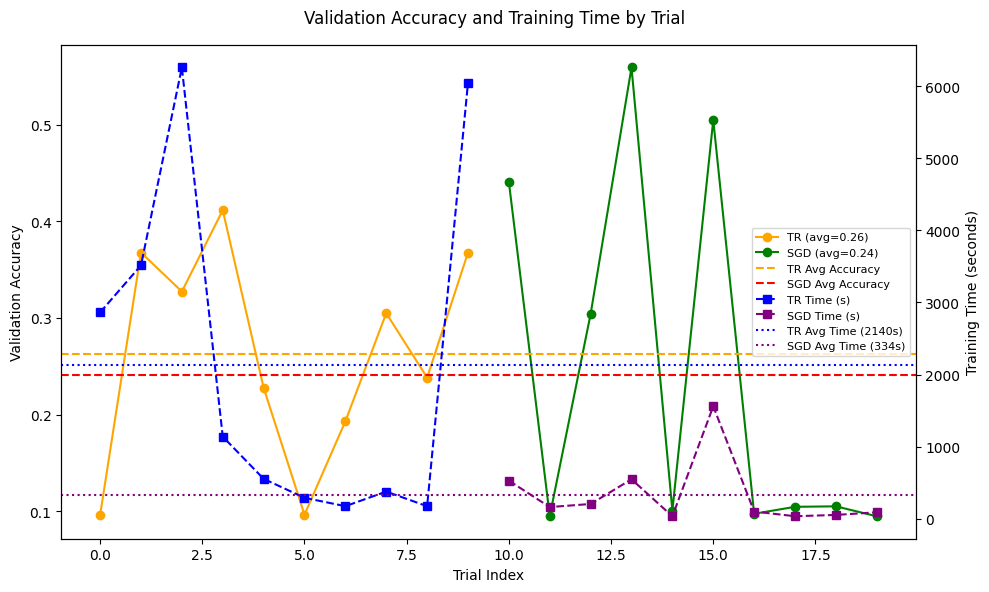

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Reconstruct your table into a DataFrame
data = {
    "optimizer": ["TR"] * 10 + ["SGD"] * 10,
    "trial": list(range(20)),
    "time": [
        2862.1, 3514.4, 6257.5, 1140.6, 555.4, 292.8, 176.4, 379.0, 176.3, 6044.5, # TR
        530.2, 164.0, 207.2, 549.1, 36.6, 1561.5, 102.6, 37.2, 55.3, 92.0  # SGD
    ],
    "accuracy": [
        0.096, 0.3676, 0.3272, 0.4114, 0.2277, 0.0963, 0.1930, 0.3048, 0.2382, 0.3675, # TR
        0.4405, 0.0949, 0.3040, 0.5591, 0.1006, 0.5047, 0.0973, 0.1045, 0.1050, 0.0947  # SGD
    ],
    "loss": [
        2.3091, 1.7389, 1.8955, 1.6011, 2.0390, 2.3238, 2.0823, 1.8259, 1.9938, 1.7707, # TR
        1.5908, 2.3491, 1.7917, 1.3512, 2.3107, 1.4129, 2.3447, 2.3074, 2.3149, 2.3089  # SGD
    ]
}

df = pd.DataFrame(data)

# Separate Trust Region and SGD trials
tr_trials = df[df["optimizer"] == "TR"]
sgd_trials = df[df["optimizer"] == "SGD"]

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot validation accuracy
ax1.plot(tr_trials["trial"], tr_trials["accuracy"], '-o', label=f'TR (avg={tr_trials["accuracy"].mean():.2f})', color='orange')
ax1.plot(sgd_trials["trial"], sgd_trials["accuracy"], '-o', label=f'SGD (avg={sgd_trials["accuracy"].mean():.2f})', color='green')

# Plot average accuracy lines
ax1.axhline(tr_trials["accuracy"].mean(), color='orange', linestyle='--', label='TR Avg Accuracy')
ax1.axhline(sgd_trials["accuracy"].mean(), color='red', linestyle='--', label='SGD Avg Accuracy')

ax1.set_xlabel('Trial Index')
ax1.set_ylabel('Validation Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Twin axis for training time
ax2 = ax1.twinx()

# Plot training time
ax2.plot(tr_trials["trial"], tr_trials["time"], 's--', color='blue', label='TR Time (s)')
ax2.plot(sgd_trials["trial"], sgd_trials["time"], 's--', color='purple', label='SGD Time (s)')

# Plot average training time lines
ax2.axhline(tr_trials["time"].mean(), color='blue', linestyle=':', label=f'TR Avg Time ({tr_trials["time"].mean():.0f}s)')
ax2.axhline(sgd_trials["time"].mean(), color='purple', linestyle=':', label=f'SGD Avg Time ({sgd_trials["time"].mean():.0f}s)')

ax2.set_ylabel('Training Time (seconds)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and Legends
fig.suptitle("Validation Accuracy and Training Time by Trial")

# Combine legends from both y-axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='center right', fontsize=8)

fig.tight_layout()
plt.show()
